출처: https://www.kaggle.com/lava18/google-play-store-apps

Google Play Store Apps
Web scraped data of 10k Play Store apps for analysing the Android market.

캐글의 앱 순위를 분석 + 앱의 분포

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import rc, font_manager
font_location = 'C:/Windows/Fonts/batang.ttc'
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)

import missingno as msno
from wordcloud import WordCloud

sns.set_style('whitegrid')

In [2]:
# raw_data = pd.read_csv('googleplaystore.csv')
df = pd.read_csv('googleplaystore.csv')

### 1. 누락된 데이터 알아보기

`missinggo`를 이용해 만든 매트릭스로 누락된 데이터를 알아봅니다. 여기서는 Rating 열의 값들의 누락이 많다는 것이 보입니다. (대략 1000 여 개가 NaN입니다.)

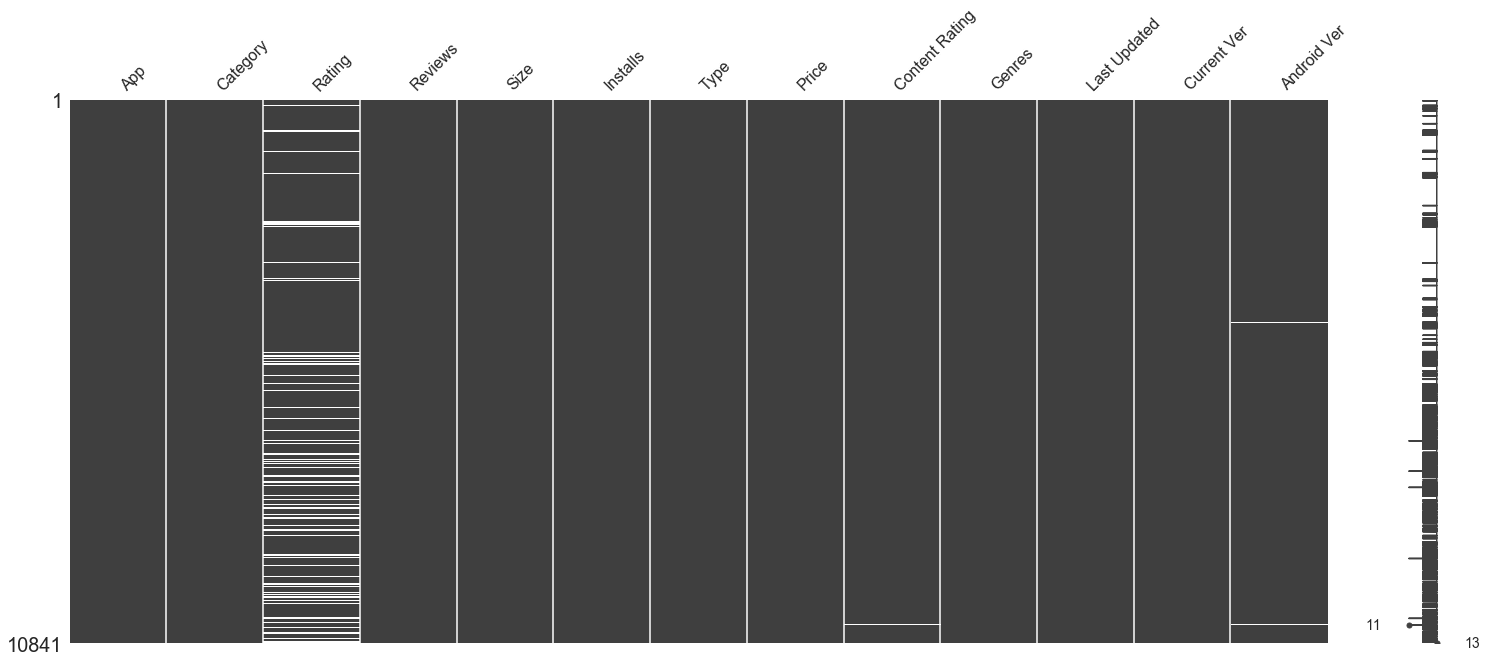

In [4]:
msno.matrix(df)

### 2. 데이터 구성

처음에는 NaN을 0으로 채웠습니다.(`fillna(0)` 사용) 하지만 그러면 Rating 열의 데이터를 평가하기 어려워지기에, 원래 상태로 유지하기로 했습니다.

Installs, Type 형식에 맞지 않는 문자열, 숫자를 지웁니다. 그리고 Reviews, Installs, Price, Size를 숫자로 바꾸고, Genres를 단순화시킵니다. 마지막으로 데이터의 중복을 제거합니다.

In [3]:
df111 = df

In [3]:
# Type
df = df[df['Type'] != '0']
df = df[df['Type'] != 0]
# Reviews
df['Reviews'] = df['Reviews'].astype('float')
# Installs
df = df[df['Installs'] != 'Free']
df['Installs'] = df['Installs'].apply(lambda x: str(x).replace('+', ''))
df['Installs'] = df['Installs'].apply(lambda x: float(str(x).replace(',', '')))
# float 다른 방법.. pd.to_numeric(df['Installs'], errors='coerce')
# Price
df['Price'] = df['Price'].apply(lambda x: float(str(x).replace('$', '')))
# Size
df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('M', '')) if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)
df['Size'] = df['Size'].astype('float')
# Genres: 예를 들어 Board와 Board;Casual Game을 Board 하나로 통일시킵니다.
df['Genres'] = df['Genres'].apply(lambda x: str(x).split(';')[0] if ';' in str(x) else x)

df = df.drop_duplicates(subset='App')

### 3. 그래프

#### 카테고리 분포도

카테고리별로 얼마나 많은 앱이 있는지를 알아봅니다. `Counter`를 사용해 만듭니다.

In [7]:
len(Counter(df['Genres']))

48

Text(0.5, 1.0, 'Category Distribution chart')

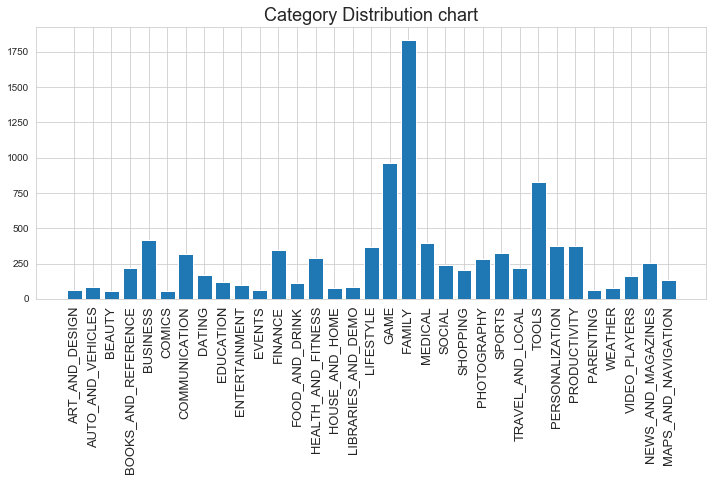

In [11]:
category_labels, category_values = zip(*Counter(df['Category']).items())

plt.figure(figsize=(12,5))
plt.bar(category_labels, category_values)
plt.xticks(category_labels,fontsize=13, rotation=90)
plt.title("Category Distribution chart", fontsize=18)

#### 카테고리와 평점

카테고리의 앱들이 받은 평점을 Violin plot으로 나타냈습니다. 

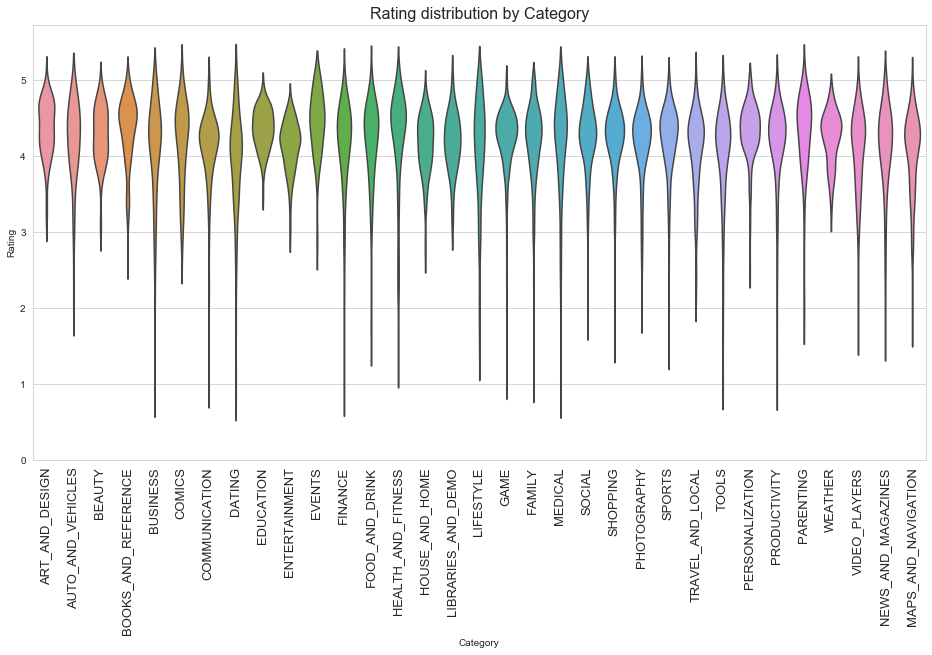

In [12]:
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.violinplot(x='Category', y='Rating', data=df, split=True, inner=None)
ax = ax.set_xticklabels(category_labels, rotation=90, fontsize=13)
ax = plt.yticks([0,1,2,3,4,5])
ax = plt.title('Rating distribution by Category', fontsize=16)

#### 평점과 리뷰의 횟수를 비교하기

산점도를 활용, 앱의 평점과 리뷰를 받은 횟수를 비교합니다.

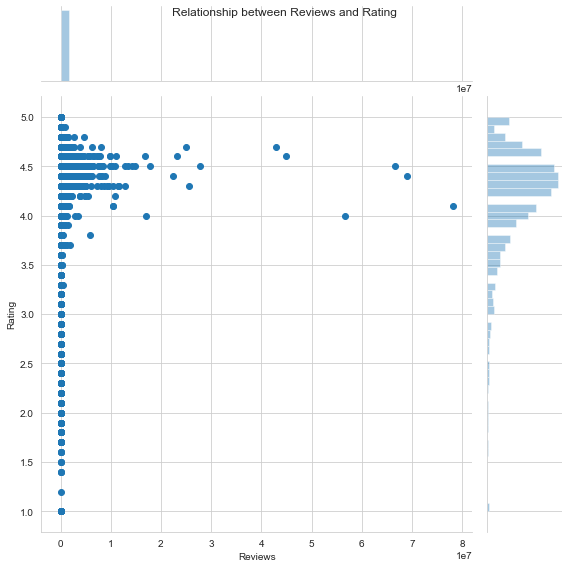

In [13]:
joint = sns.jointplot(x='Reviews', y='Rating', data=df, height=8)
joint.set_axis_labels(xlabel='Reviews', ylabel='Rating')
joint = joint.fig.suptitle('Relationship between Reviews and Rating')

#### 카테고리와 가격 비교

이번에는 카테고리와 가격입니다. 가격이 100달러를 넘는 앱들은 기능이 없는 가짜 앱들입니다. 그래서 100달러 이하인 데이터로 만든 데이터프레임으로 Strip plot을 만들었습니다.

In [14]:
df2 = df.loc[df['Price'] <= 100]

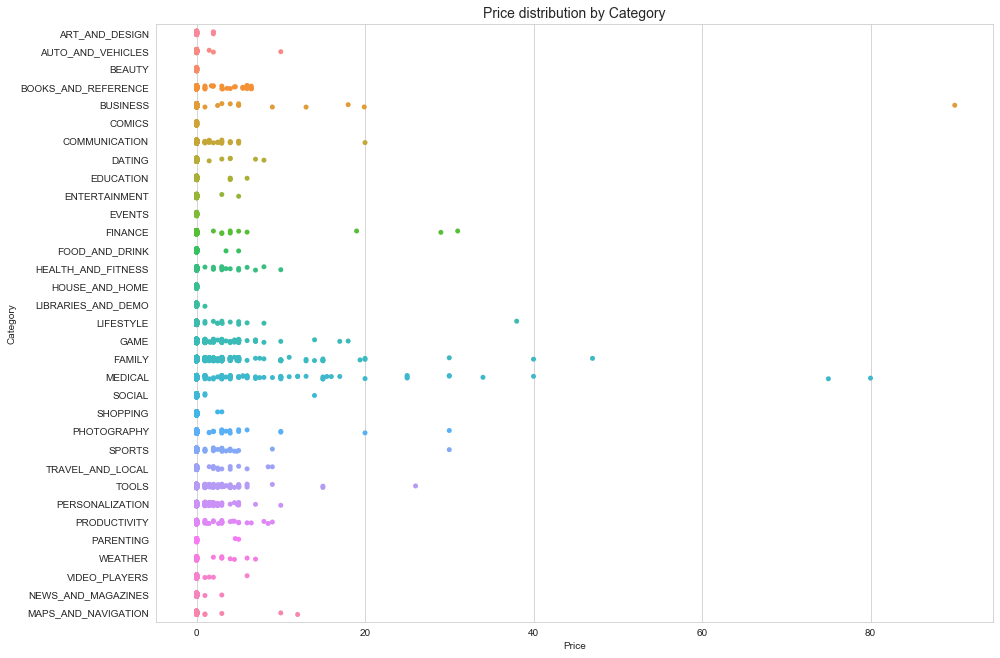

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 11)
s_plot = sns.stripplot(x='Price', y='Category', data=df2)
s_plot = ax.set_title('Price distribution by Category', fontsize=14)

#### 가격와 평점 비교하기

100달러 이하인 데이터를 이용, 가격과 평점을 비교합니다.

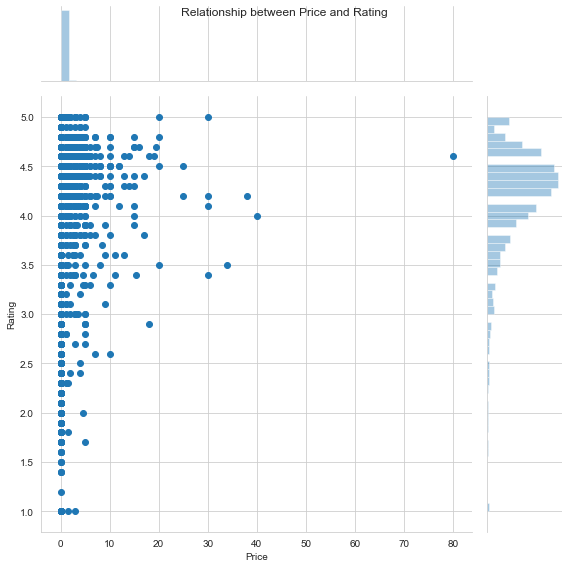

In [16]:
joint2 = sns.jointplot(x='Price', y='Rating', data=df2, height=8)
joint2 = joint2.set_axis_labels(xlabel='Price', ylabel='Rating')
joint2 = joint2.fig.suptitle('Relationship between Price and Rating')

#### 앱의 크기와 평점 비교하기

처음에 Size 열의 'Varies with device'을 NaN으로 바꿨습니다. 그래서 NaN이 없는 새로운 데이터 프레임으로 평점과 비교하겠습니다.

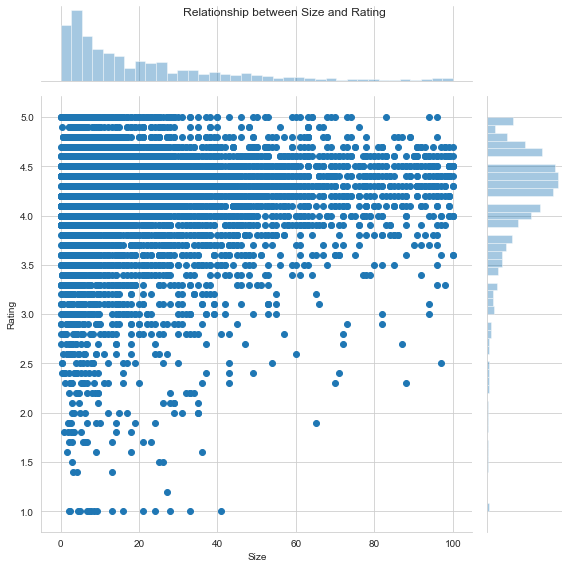

In [66]:
df3 = df[df['Size'] != None]

joint4 = sns.jointplot(x='Size', y='Rating', data=df3, height=8)
joint4 = joint4.set_axis_labels(xlabel='Size', ylabel='Rating')
joint4 = joint4.fig.suptitle('Relationship between Size and Rating')

#### 추가- GAME 카테고리 앱의 크기와 평점 비교

게임의 경우, 고사양일수록 그만큼 앱의 크기가 커집니다. 그래서 앱의 크기와 평점의 관계를 비교해, 이용자가 고사양 게임을 선호하는지를 알아보겠습니다.

Text(0.5, 1.0, 'Relationship between Rating and Size-GAME Category')

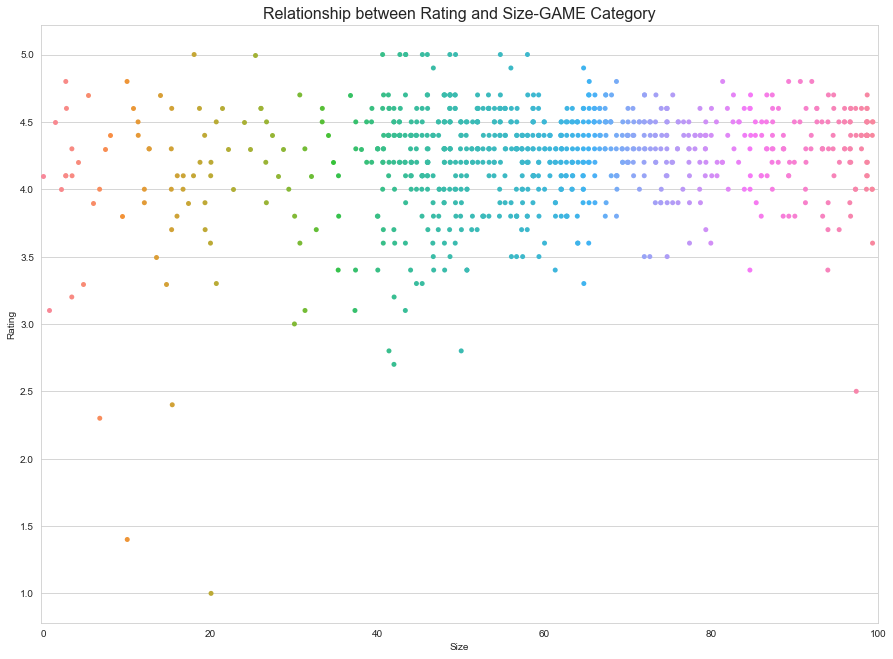

In [117]:
# https://stackoverflow.com/questions/20335290/matplotlib-plot-set-x-ticks
fig, ax = plt.subplots()
fig.set_size_inches(15, 11)
ax = sns.stripplot(x='Size', y='Rating', data=df.loc[df['Category'] == 'GAME'])
ax.set_xticks(np.arange(180, step=30))
ax.set_xticklabels([0, 20, 40, 60, 80, 100])
ax.set_title('Relationship between Rating and Size-GAME Category', fontsize=16)

#### 장르 워드클라우드

어떤 장르의 앱이 많은지 워드클라우드를 통해 알아봅니다.

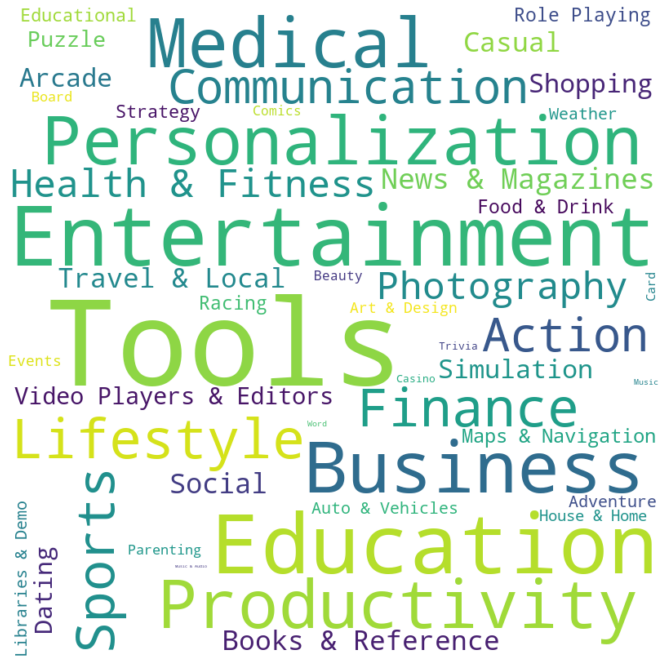

In [18]:
wordcloud = WordCloud(
    background_color='white', 
    width=800, 
    height=800
)

wordcloud = wordcloud.generate_from_frequencies(Counter(df['Genres']))

plt.figure(figsize=(14, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### 추가- 상위 1000위까지의 장르

In [118]:
# 설치 횟수가 많은 순으로 1000위까지 추출합니다.
df4 = df.sort_values(by='Installs', ascending=False).head(1000)
# 장르 이름이 많은 순으로 정리해 변수에 저장합니다.
labels, values = zip(*Counter(df4['Genres']).most_common())
# 위의 데이터를 기반으로 데이터 프레임을 만들고, Percentage(%)행도 포함시켰습니다.
genres_df = pd.DataFrame(values, index=labels, columns=['Number']).head(10).T
genres_df.loc['Percentage(%)'] = genres_df.iloc[0].apply(lambda x: float(x / 1000) * 100)

genres_df

,Tools,Photography,Action,Arcade,Casual,Productivity,Shopping,Social,Sports,Communication
Number,103.0,90.0,85.0,62.0,58.0,56.0,53.0,48.0,45.0,38.0
Percentage(%),10.3,9.0,8.5,6.2,5.8,5.6,5.3,4.8,4.5,3.8
